In [2]:
import xml.etree.ElementTree as ET
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Get a list of words in the textblock along with its corresponding references
# words_arr: a list of words in the text block 
# ref_arr: a list of refs which correspond the each word in words_arr
def read_ink(path):
    tree = ET.parse(path)
    root = tree.getroot()

    traceView = root.find("traceView")

    traceView2 = traceView.findall("traceView")

    textBlockRoots = []

    for t in traceView2:
        annotation = t.find("annotation")

        if (annotation.text == "Textblock"):
            textBlockRoots.append(t)

    words_arr = []
    ref_arr = []

    for textBlock in textBlockRoots:
        for textLine in textBlock.findall("traceView"):
            string = textLine[1].text

            for i in range(2, len(textLine)):
                wordElement = textLine[i]
                word = wordElement[1].text

                if word is not None:
                    words_arr.append(word)

                    refs = wordElement.findall('traceView')
                    
                    ref_list = []
                
                for ref in refs:
                    if 'traceDataRef' in ref.attrib:
                        ref_list.append(ref.attrib['traceDataRef'])

                ref_arr.append(ref_list)
                    
    return words_arr, ref_arr
    

In [3]:
# Returns a dict that maps ref id -> digital ink time series
def get_digital_ink(path):
    tree = ET.parse(path)
    root = tree.getroot()
    traces = root.findall("trace")

    digital_ink_dict = {}


    for trace in traces:
        digital_ink_dict[trace.attrib['{http://www.w3.org/XML/1998/namespace}id']] = trace.text

    return digital_ink_dict

In [4]:
def add_value(series, v):
    series.append(series[len(series) - 1] + v)

def add_initial_point(data, x, y, t, p):
    starting_data = data.split(" ")

    start_x = float(starting_data[0])
    start_y = float(starting_data[1])
    start_t = float(starting_data[2])
    start_p = float(starting_data[3])

    x.append(start_x)
    y.append(start_y)
    t.append(start_t)
    p.append(start_p)

In [5]:
# Converts a time series of v,v',v" into a time series of purely v values 
# Basically converts first and second derivatives into normal points
def construct_time_series(raw_time_series):
    raw_time_series = raw_time_series.strip()
    points = raw_time_series.split(",")

    x, y, t, p = [], [], [], []
    
    # Starting data
    if len(points) >= 1:
        add_initial_point(points[0], x, y, t, p)

    # 2nd set of data (1st derivative)
    if len(points) >= 2:
        trace_v = points[1].split("\'")

        v_x = float(trace_v[1])
        v_y = float(trace_v[2])
        v_t = float(trace_v[3])
        v_p = float(trace_v[4])

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    # 3rd set of data (2nd derivative)
    if len(points) >= 3:
        trace_acc = points[2].split("\"")

        v_x += float(trace_acc[1])
        v_y += float(trace_acc[2])
        v_t += float(trace_acc[3])
        v_p += float(trace_acc[4]) 

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    # for all other sets of data 
    for i in range(3, len(points)):
        values = re.findall("-?\d*\.?\d+", points[i])

        v_x += float(values[0])
        v_y += float(values[1])
        v_t += float(values[2])
        v_p += float(values[3])

        add_value(x, v_x)
        add_value(y, v_y)
        add_value(t, v_t)
        add_value(p, v_p)

    return x, y, t, p  

In [24]:
# Fill time gaps for 1D array with time dimensions as shown below
def get_time_gaps(t):
    time_gaps = np.diff(t)

    start_t = t[0]
    end_t = t[len(t) - 1]

    t_filled = []
    t_filled.append(start_t)
    
    for i in range(0, len(time_gaps)):
        time_gap = time_gaps[i]
        num_intervals = round(time_gap / 0.013)

        if (num_intervals == 0):
            raise Exception("Num Intervals cannot be 0")

        curr_time = t[i]
        next_time = t[i+1]

        if num_intervals != 1:
            for i in range(1, num_intervals):
                t_filled.append(curr_time + 0.013 * i)
        
        t_filled.append(next_time)

    return t_filled        

In [6]:
words_arr, ref_arr = read_ink("datasets/001e.inkml")

['And', 'he', 'had', 'a', 'feeling', '-', 'thanks', 'to', 'the', 'girl', '-', 'that', 'things', 'would', 'get', 'worse', 'before', 'they', 'got', 'better', '.', 'They', 'had', 'the', 'house', 'cleaned', 'up', 'by', 'noon', ',', 'and', 'Wilson', 'sent', 'the', 'boy', 'out', 'to', 'the', 'meadow', 'to', 'bring', 'in', 'the', 'horses']


In [7]:
ref_dict = get_digital_ink("./datasets/001.inkml")

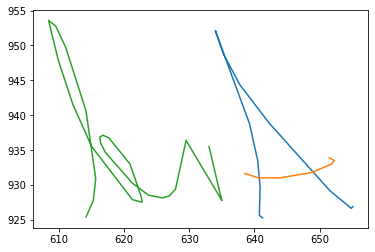

In [23]:
x,y,t,p = construct_time_series(ref_dict['t0'].strip())
t_filled = get_time_gaps(t)
x_filled = np.interp(t_filled, t, x)
y_filled = np.interp(t_filled, t, y)
plt.plot(x_filled,y_filled)
x,y,t,p = construct_time_series(ref_dict['t1'].strip())
t_filled = get_time_gaps(t)
x_filled = np.interp(t_filled, t, x)
y_filled = np.interp(t_filled, t, y)
plt.plot(x_filled,y_filled)
x,y,t,p = construct_time_series(ref_dict['t2'].strip())
t_filled = get_time_gaps(t)
x_filled = np.interp(t_filled, t, x)
y_filled = np.interp(t_filled, t, y)
plt.plot(x_filled,y_filled)
plt.show()

In [97]:
for key in ref_dict.keys():
    x, y, t, p = construct_time_series(ref_dict[key])

In [21]:
for f in glob.glob("datasets/*1*.inkml"):
    print(f)
    words_arr, ref_arr = read_ink(f)

# words_arr, ref_arr = read_ink('datasets/001.inkml')


datasets/001f.inkml
And
he
had
a
feeling
-
thanks
to
the
girl
-
that
things
would
get
worse
before
they
got
better
.
They
had
the
house
cleaned
up
by
noon
,
and
Wilson
sent
the
boy
out
to
the
meadow
to
bring
in
the
horses
.
datasets/001g.inkml
And
he
had
a
feeling
-
thanks
to
the
girl
-
that
things
would
get
worse
before
they
got
better
.
They
had
the
house
cleaned
by
noon
,
and
Wilson
sent
the
boy
out
to
the
meadow
to
bring
in
the
horses
.
datasets/001.inkml
And
he
had
a
feeling
-
thanks
to
the
girl
-
that
things
would
get
worse
before
they
None
got
better
.
They
had
the
house
cleaned
up
by
noon
,
and
Wilson
sent
the
boy
out
to
the
meadow
to
bring
in
the
horses
.
He
stoat
on
the
porch
and
watched
him
struggling
with
the
heavy
harness
,
and
finally
went
over
to
help
him
.
datasets/001e.inkml
And
he
had
a
feeling
-
thanks
to
the
girl
-
that
things
would
get
worse
before
they
got
better
.
They
had
the
house
cleaned
up
by
noon
,
and
Wilson
sent
the
boy
out
to
the
meadow
to
bring
in
the
ho